In [1]:
import fastai
import math
import os
import pprint
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

from datetime import (
    datetime
)

from sklearn.preprocessing import (
    StandardScaler
)

from fastai.tabular.all import (
    LinBnDrop
)

from fastai.layers import (
    Identity

)

from typing import (
    Callable,
    Dict,
    List,
    Tuple
)

from Quick.cleaning.loading import (
    examine_dataset,
    remove_infs_and_nans
)

from Quick.cleaning.utils import (
    get_file_path
)

from Quick.runners.deep import (
    run_deep_nn_experiment
)

from Quick.runners.residual import (
    run_residual_deep_nn_experiment
)

from Quick.runners.sk import (
    run_sk_experiment
)

from Quick.runners.torch import (
    run_torch_nn_experiment
)

from rff.layers import (
    GaussianEncoding,
)

from Quick.constants import *

pretty = pprint.PrettyPrinter(indent=4).pprint

In [2]:
use_gpu: bool = False

if(use_gpu):

    if(torch.backends.mps.is_available()): # For Mac M1/M2 chips
        device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    else: # For NVIDIA cuda chips
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

else:
    device = torch.device('cpu')

print(f'We are currently using the device: {device}')

We are currently using the device: cpu


In [3]:
data_path_1: str = r'C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B'
data_sets_1: list = [
    'TimeBasedFeatures-Dataset-15s-AllinOne.csv'
]

file_path_1: callable = get_file_path(data_path_1)
file_set_1: list = list(map(file_path_1, data_sets_1))

print(f'The datasets we will be working with are:')
pretty(file_set_1)

The datasets we will be working with are:
[   'C:\\python\\TrafficFlowForecasting\\warins_experiments\\data\\Scenario '
    'B\\TimeBasedFeatures-Dataset-15s-AllinOne.csv']


In [4]:
dataset_1 = examine_dataset(0, file_set_1, data_sets_1)

Dataset 0/1: We now look at C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv


Loading Dataset: C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv
	To Dataset Cache: ./cache/TimeBasedFeatures-Dataset-15s-AllinOne.csv.pickle


        File:				C:\python\TrafficFlowForecasting\warins_experiments\data\Scenario B\TimeBasedFeatures-Dataset-15s-AllinOne.csv  
        Job Number:			0
        Shape:				(18758, 25)
        Samples:			18758 
        Features:			25
    


In [5]:
# we are going to select a random subset of our data

df = dataset_1['Dataset'].sample(frac=1, random_state=42) #just using all of it

In [6]:
dataset_1['Dataset'].shape

(18758, 25)

In [7]:
df.shape

(18758, 25)

In [8]:
df.columns

Index(['Unnamed: 0', 'duration', 'total_fiat', 'total_biat', 'min_fiat',
       'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat',
       'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat',
       'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active',
       'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle',
       'std_idle', 'class1'],
      dtype='object')

In [9]:
df = df.drop(columns=['Unnamed: 0'])
df.columns

Index(['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat',
       'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond',
       'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat',
       'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active',
       'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'class1'],
      dtype='object')

In [10]:
flow_iat_columns = [
    'min_flowiat', 
    'max_flowiat', 
    'mean_flowiat',
    'std_flowiat',
]

flow_columns = [
    'flowPktsPerSecond',
    'flowBytesPerSecond',
    'duration',
]

fiat_columns = [
    'total_fiat',
    'min_fiat',
    'max_fiat',
    'mean_fiat',
]

biat_columns = [
    'total_biat', 
    'min_biat',
    'max_biat', 
    'mean_biat',
]

active_columns = [
    'min_active', 
    'mean_active', 
    'max_active', 
    'std_active',
]

idle_columns = [
    'min_idle', 
    'mean_idle', 
    'max_idle', 
    'std_idle',
]

label_columns = [
    'class1', 
]


feature_groups = {
    'flow_iat': flow_iat_columns,
    'flow': flow_columns,
    'fiat': fiat_columns,
    'biat': biat_columns,
    'active': active_columns,
    'idle': idle_columns,
}

features = []

for group in feature_groups.values():
    features.extend(group)

columns = features + label_columns

# we reorder the columns
df = df[columns]


In [11]:
df.head()

,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,flowPktsPerSecond,flowBytesPerSecond,duration,total_fiat,min_fiat,max_fiat,...,mean_biat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
13570,1.0,3880733.0,1.364785e+05,6.152935e+05,7.403488,2183.418445,13101932.0,66.0,3880916.0,3.195562e+05,...,8.083099e+05,2006069.0,3.251170e+06,3992186.0,862211.405316,1871670.0,2964215.25,3880733.0,884384.957450,BROWSING
5843,-1.0,-1.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,-1.0,-1.0,0.000000e+00,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000,-1.0,0.00,-1.0,0.000000,CHAT
17888,194.0,9831086.0,3.277185e+06,5.675845e+06,0.406853,77.708969,9831555.0,9831361.0,9831361.0,9.831361e+06,...,0.000000e+00,9831361.0,9.831361e+06,9831361.0,0.000000,9831086.0,9831086.00,9831086.0,0.000000,P2P
16530,8.0,11730216.0,1.676370e+05,1.353519e+06,6.044806,1838.098151,12572778.0,8.0,11755480.0,3.669490e+05,...,1.855974e+06,11870380.0,1.190000e+07,11870380.0,0.000000,11730216.0,11700000.00,11730216.0,0.000000,BROWSING
16289,8.0,3302178.0,9.669848e+04,4.857434e+05,10.451439,3188.349131,9089657.0,8.0,3406304.0,2.164204e+05,...,6.554136e+05,1955970.0,2.916389e+06,3550257.0,845821.939207,1721182.0,2664910.00,3302178.0,833861.731166,BROWSING


In [12]:
class MultiheadAttention(nn.Module):
    def __init__(
        self,
        embedding_size     : int,
        heads              : int,
        device             : torch.device,
    ) -> None:
    
        super(MultiheadAttention, self).__init__()

        self.embedding_size      = embedding_size
        self.heads               = heads

        if embedding_size % heads != 0:
            raise Exception(f'embedding_size must be divisible by heads. embedding_size: {embedding_size}, heads: {heads}')

        self.query = nn.Linear(embedding_size, embedding_size, device = device)
        self.key   = nn.Linear(embedding_size, embedding_size, device = device)
        self.value = nn.Linear(embedding_size, embedding_size, device = device)

        # The constant that is used to scale the dot product, we precompute it for efficiency
        self.scaling_denominator = torch.tensor(
            math.sqrt(embedding_size // heads), 
            dtype=torch.float32, 
            device=device
        )

        self.softmax = nn.Softmax(dim=-1)

    def forward(
        self, 
        q: torch.Tensor, 
        v: torch.Tensor,
        k: torch.Tensor
    ):
        '''
            We perform multihead attention on the query embeddings using the encoder state as the key and value

            shape:
                x: (batch_size, total_num_queries, embedding_size)
                encoder_state: (batch_size, lookback_size, embedding_size)
                output: (batch_size, total_num_queries, embedding_size)
        '''

        # print(f"q: {q.shape}")

        key  : torch.Tensor = self.key(k)
        value: torch.Tensor = self.value(v)
        query: torch.Tensor = self.query(q)

        # we split the query, key, and value into heads
        query = query.reshape(
            query.shape[0],
            query.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        key = key.reshape(
            key.shape[0],
            key.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        value = value.reshape(
            value.shape[0],
            value.shape[1],
            self.heads,
            self.embedding_size // self.heads
        ).transpose(1, 2)

        # we perform the attention
        pre_attention = torch.matmul(query, key.transpose(-2, -1))/self.scaling_denominator

        # print(f"pre_attention: {pre_attention.shape}")

        # we apply the softmax to the pre_attention
        distribution = self.softmax(pre_attention)


        # print(f"distribution: {distribution.shape}")
        # print(f"value: {value.shape}")

        # we multiply the distribution by the value to give the attention output
        attention = torch.einsum('bhqk,bhkd->bhqd', distribution, value)

        # print(f"attention: {attention.shape}")


        # Finally, we reshape the attention, transitioning between the following shapes:
        #       attention shape: batch_size, heads, total_num_queries, embedding_size // heads
        #       final shape: batch_size, total_num_queries, embedding_size
        full_attention = attention.transpose(1, 2).reshape(
            attention.shape[0],
            attention.shape[-2],
            self.embedding_size
        )

        # print(f"full_attention: {full_attention.shape}")

        return full_attention


In [13]:
class Encoder(nn.Module):
    def __init__(
        self,
        embedding_size     : int,
        heads              : int,
        device             : torch.device,
        forward_expansion  : int      = 4,
        dropout            : float    = 0.0,
        pre_norm           : bool     = False,
        activation = nn.ReLU(),
    ) -> None:
    
        super(Encoder, self).__init__()

        self.embedding_size     = embedding_size
        self.heads              = heads
        self.forward_expansion  = forward_expansion
        self.dropout            = dropout
        self.activation         = activation
        self.pre_norm           = pre_norm

        self.attention = MultiheadAttention(embedding_size, heads, device)

        self.norm_1 = nn.LayerNorm(embedding_size)
        self.norm_2 = nn.LayerNorm(embedding_size)

        self.hidden_size = int(embedding_size * forward_expansion)

        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_size, self.hidden_size),
            self.activation,
            nn.Linear(self.hidden_size, embedding_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        x: torch.Tensor,
    ) -> torch.Tensor:
        '''
            We perform multihead attention. 
            
            If we prenorm, we apply layer norm before the attention and feed forward layers,
                otherwise we apply it after 
        '''

        # print(f"x: {x.shape}")

        if self.pre_norm:
            x_hat = self.norm_1(x)
            attention = self.attention(x_hat, x_hat, x_hat)
            x_hat = x + self.dropout(attention)
        else: 
            attention = self.attention(x, x, x)
            x_hat = self.norm_1(x + self.dropout(attention))


        if self.pre_norm:
            x_hat = self.norm_2(x_hat)
            feed_forward = self.feed_forward(x_hat)
            x_hat = x_hat + self.dropout(feed_forward)
        else:
            feed_forward = self.feed_forward(x_hat)
            x_hat = self.norm_2(x_hat + self.dropout(feed_forward))

        return x_hat


In [14]:
class GroupEmbedding(nn.Module):

    def __init__(
        self,
        embedding_size: int,
        input_size: int,
        use_rff: bool,
        device: torch.device,
        rff_dim: int = 64,
        rff_std: float = 2.5,
        learnable_rff_std: bool = False,
        activation: nn.Module = nn.ReLU(),
    ) -> None:
        super(GroupEmbedding, self).__init__()

        self.embedding_size = embedding_size
        self.device = device
        self.use_rff = use_rff
        self.rff_dim = rff_dim
        self.rff_std = rff_std
        self.learnable_rff_std = learnable_rff_std


        if use_rff:
            self.rff = GaussianEncoding(
                rff_std,
                input_size,
                rff_dim
            ).to(device)

        if learnable_rff_std:
            self.std_vec = nn.Parameter(torch.ones(input_size, device=device))
            
        
        self.linear_size = input_size + 2*self.rff_dim if use_rff else input_size

        self.linear = nn.Linear(
            self.linear_size,
            embedding_size, 
            device=device
        )

        self.activation = activation

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
            We embed the input using the strategy found suggested in the following papers: 
                Time2Vec: Learning a Vector Representation of Time: 
                    https://arxiv.org/abs/1907.05321

                On Embeddings for Numerical Features in Tabular Deep Learning: 
                    https://arxiv.org/abs/2203.05556
                    
                Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains: 
                    https://arxiv.org/abs/2006.10739
        
            We first pass the the input through an encoding layer, which is either an RFF layer or nothing.
            If there is an encoding layer, we concatenate the encoding with the input.
            Then, we pass the output of the encoding layer through a linear layer and an activation function.
        '''

        if self.use_rff:
            if self.learnable_rff_std:
                x = x * self.std_vec

            rff = self.rff(x)
            # print(f"rff: {rff.shape}")
            # print(f"x: {x.shape}")
            x = torch.cat((x, rff), dim=-1)

        # print(f'post rff x shape: {x.shape}')
        # print(f"self.linear_size: {self.linear_size}")

        x = self.linear(x)
        x = self.activation(x)

        return x

        

In [15]:
class DebugLayer(nn.Module):
    def __init__(
        self,
        verbose: bool = False,
        message: str = '',
    ) -> None:
        super(DebugLayer, self).__init__()
        self.verbose = verbose
        self.message = message

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.verbose:
            print(f"{self.message}: {x.shape}")
            self.verbose = False
            
        return x



Shape of Input Data: (18758, 24)
input features: 23
output features: 7


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 7])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.612111,1.484672,0.503599,0.267652,0.668791,0.376621,0.189043,0.147632,0.267652,00:05
1,1.752962,1.756186,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:05
2,1.762456,1.753759,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:05
3,1.771288,1.753161,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:06
4,1.747932,1.754532,0.256998,0.142857,0.500000,0.000000,0.058415,0.036714,0.142857,00:07
5,1.756617,1.755739,0.256998,0.142857,0.500000,0.000000,0.058415,0.036714,0.142857,00:07
6,1.749307,1.752900,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:07
7,1.757385,1.752449,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:08
8,1.753873,1.752364,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:07
9,1.755679,1.752408,0.279925,0.142857,0.500000,0.000000,0.062487,0.039989,0.142857,00:07


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


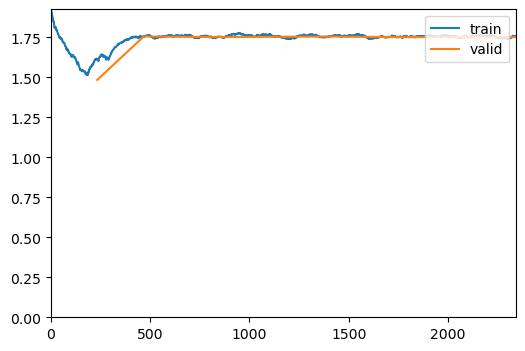

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.7524077892303467, accuracy:  27.99%
Learnable Parameters: 			151733


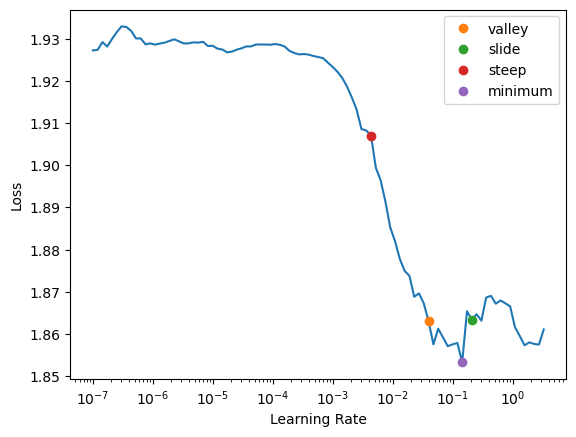

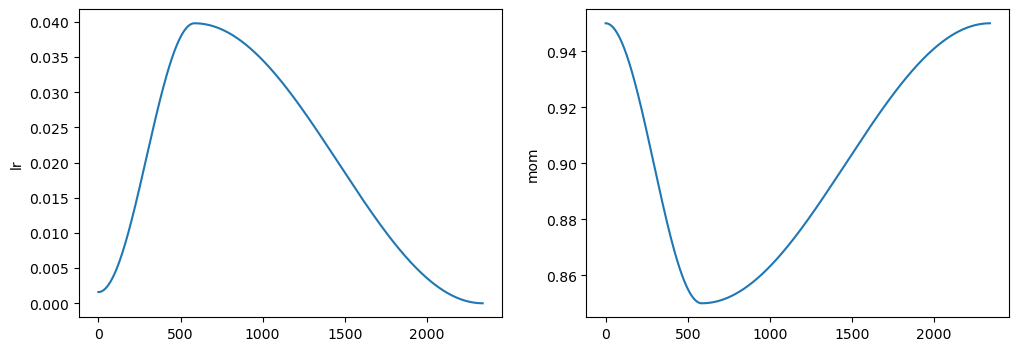

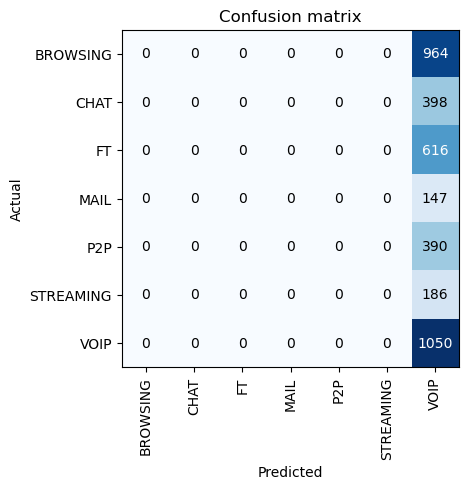

In [16]:
class FlowTransformer(nn.Module):

    def __init__(
        self, 
        input_features = 62, 
        output_features = 8, 
        device = torch.device('cpu'), 
        config: dict = {
            'feature_groups': feature_groups,
            'activation': nn.ReLU(),
            'verbose': True,
            'embeddings': {
                'embedding_size': 64,
                'use_rff': True,
                'rff_dim': 64,
                'rff_std': 2.5,
                'learnable_rff_std': False,
            },
            'encoder':{
                'layers': 2,
                'heads': 4,
                'forward_expansion': 2,
                'pre_norm': False,
                'dropout': 0.0,
            },
            'aggregation': {
                'type': 'LSTM',
                'layers': 1,
            },
            'classification_head': {
                'layers': 2,
                'hidden_size': 64,
                'batch_norm': False,
                'activation': nn.ReLU(),
            }
        }
    ):
        '''
            This will be a transformer that takes feature groups and transforms them into
                embedding vectors. The embedding vectors will pass through a series of
                encoder layers and then will be aggregated into a single vector. This vector
                will then be passed into a classification head.

            We will be using this in conjunction with a test harness in the quick library.
                Every model that is used in this manner will need to have the 4 init parameters:
                    # of input features
                    # of output features
                    device
                    a config dictionary

            The config dictionary will be used to specify the architecture of the model, and 
                even when not using a config, one must be passed through the test harness in order
                to work correctly.
            
        '''

        super(FlowTransformer, self).__init__()

        self.input_features = input_features
        self.output_features = output_features
        self.device = device
        self.config = config
        self.verbose = config['verbose']

        print(f'input features: {self.input_features}')
        print(f'output features: {self.output_features}')

        # First, we create our embeddings for each feature group

        self.feature_groups = config['feature_groups']
        self.embedding_size = config['embeddings']['embedding_size']

        self.use_rff = config['embeddings']['use_rff']
        self.rff_dim = config['embeddings']['rff_dim']
        self.rff_std = config['embeddings']['rff_std']
        self.learnable_rff_std = config['embeddings']['learnable_rff_std']

        self.activation = config['activation']



        self.embeddings = nn.ModuleDict()

        for group, columns in self.feature_groups.items():
            self.embeddings[group] = GroupEmbedding(
                config['embeddings']['embedding_size'],
                len(columns),
                self.use_rff,
                device,
                self.rff_dim,
                self.rff_std,
                self.learnable_rff_std,
                self.activation
            )

        # Next, we create our encoder layers

        self.encoder_layers = config['encoder']['layers']
        self.encoder_heads = config['encoder']['heads']
        self.encoder_forward_expansion = config['encoder']['forward_expansion']
        self.encoder_pre_norm = config['encoder']['pre_norm']
        self.encoder_dropout = config['encoder']['dropout']

        encoder_layers = [
            Encoder(
                self.embedding_size,
                self.encoder_heads,
                self.device,
                self.encoder_forward_expansion,
                self.encoder_dropout,
                self.encoder_pre_norm,
                self.activation
            ) for _ in range(self.encoder_layers)
        ]
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Now, we create our aggregation layer
        
        self.aggregation_type = config['aggregation']['type']
        

        # Add your own aggregation layers here
        if self.aggregation_type == 'LSTM':
            self.aggregation = nn.LSTM(
                input_size = self.embedding_size,
                hidden_size = self.embedding_size,
                num_layers = config['aggregation']['layers'],
                batch_first = True,
            ).to(device)
        else:
            raise Exception(f'aggregation type {self.aggregation_type} not supported')

    
        # Finally, we create our classification head
        self.classification_head_layers = config['classification_head']['layers']
        self.classification_head_hidden_size = config['classification_head']['hidden_size']
        self.classification_head_batch_norm = config['classification_head']['batch_norm']
        self.classification_head_activation = config['classification_head']['activation']

        self.classification_head = []
        
        for i in range(self.classification_head_layers):
                
            input_size = self.embedding_size if i == 0 else self.classification_head_hidden_size

            self.classification_head.append(
                nn.Linear(
                    input_size,
                    self.classification_head_hidden_size,
                    device = self.device
                )
            )

               
            if self.classification_head_batch_norm:
                self.classification_head.append(
                    nn.BatchNorm1d(
                        self.classification_head_hidden_size,
                        device = self.device
                    )
                )

            self.classification_head.append(
                self.classification_head_activation
            )

            if self.verbose:
                self.classification_head.append(
                    DebugLayer(
                        verbose = self.verbose, 
                        message = f"Classification Head Layer {i}"
                    )
                )

        self.classification_head.append(
            nn.Linear(
                self.classification_head_hidden_size,
                self.output_features,
                device = self.device
            )
        )

        self.classification_head = nn.Sequential(*self.classification_head)


        self.flag = config['verbose']

    def forward(self, x):

        # First, we embed the input
        embeddings = []
        current_idx = 0

        batch_size = x.shape[0]

        for group, columns in self.feature_groups.items():
            group_embedding = self.embeddings[group](x[:, current_idx:current_idx + len(columns)])
            group_embedding = group_embedding.reshape(batch_size, 1, self.embedding_size)
            embeddings.append(group_embedding)
            current_idx += len(columns)

        # Next, we concatenate the embeddings
        embedding_tensor = torch.cat(embeddings, dim=1)

        # print(f'embedding tensor shape: {embedding_tensor.shape}')

        # Then, we pass the embeddings through the encoder layers
        embeddings = self.encoder(embedding_tensor)

        # Next, we aggregate the embeddings
        if self.aggregation_type == 'LSTM':
            embeddings, _ = self.aggregation(embeddings)
            # print(f"Raw aggregation shape: {embeddings.shape}")
            embeddings = embeddings[:, -1, :].reshape(batch_size, self.embedding_size)
            # print(f"Post aggregation shape: {embeddings.shape}")

        # Finally, we pass the embeddings through the classification head
        output = self.classification_head(embeddings)


        if self.flag:
            print(f"embeddings shape: {embeddings.shape}")
            print(f"aggregated embeddings shape: {embeddings.shape}")
            print(f"output shape: {output.shape}")

            self.flag = False

        # raise Exception('stop')
        return output

results_flow_transformer_1 = run_torch_nn_experiment(
    df,
    dataset_1['File'],
    target_label='class1',
    model=FlowTransformer,
    # categorical=None, #would be nice if I could put None here instead of s
    config={
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    },
)


model = results_flow_transformer_1.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [17]:
df['class1'].value_counts()

VOIP         5097
BROWSING     5000
FT           2950
CHAT         2086
P2P          1928
STREAMING     957
MAIL          740
Name: class1, dtype: int64

Shape of Input Data: (18758, 24)
input features: 23
output features: 7


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 7])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.488394,1.516152,0.497734,0.299058,0.703812,0.381562,0.250902,0.230552,0.299058,00:06
1,1.390057,1.803075,0.371101,0.220427,0.569175,0.220190,0.188695,0.256567,0.220427,00:06
2,1.341090,1.297453,0.513463,0.273303,0.757232,0.409607,0.198966,0.198275,0.273303,00:06
3,1.374375,1.516866,0.493735,0.262181,0.703645,0.359375,0.184942,0.143912,0.262181,00:06
4,1.321370,1.322935,0.509997,0.271269,0.716125,0.404496,0.197530,0.161982,0.271269,00:06
5,1.313249,1.264192,0.520928,0.277681,0.759507,0.434388,0.206426,0.234952,0.277681,00:06
6,1.283805,1.473162,0.520928,0.278274,0.692765,0.439919,0.212645,0.245751,0.278274,00:06
7,1.247065,1.369962,0.555319,0.312364,0.748900,0.456437,0.267713,0.294424,0.312364,00:06
8,1.236486,1.564402,0.524927,0.288632,0.685959,0.411626,0.235273,0.234507,0.288632,00:06
9,1.207960,1.345117,0.542789,0.299709,0.748677,0.435791,0.248245,0.249912,0.299709,00:05


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


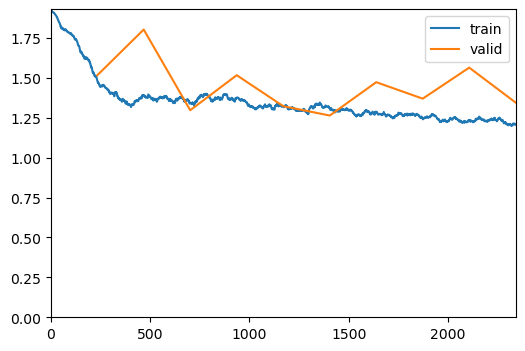

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.3451168537139893, accuracy:  54.28%
Learnable Parameters: 			151733


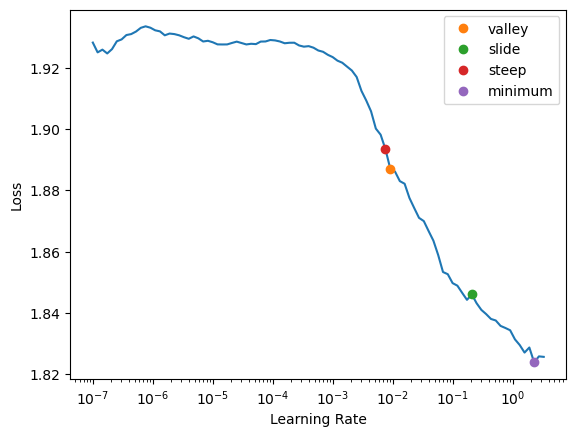

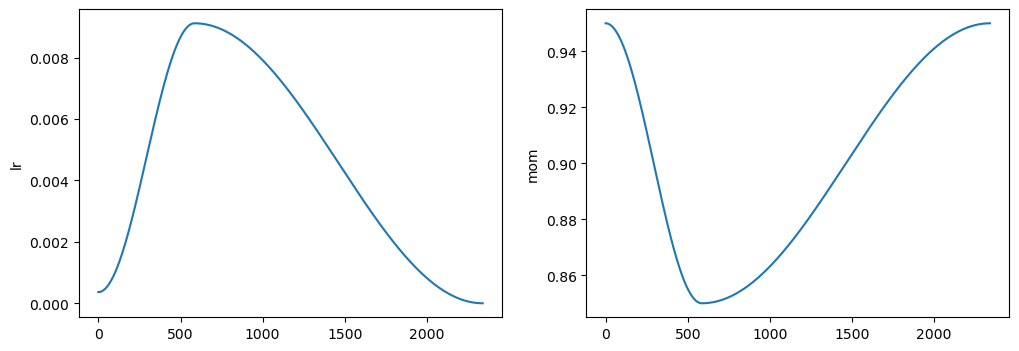

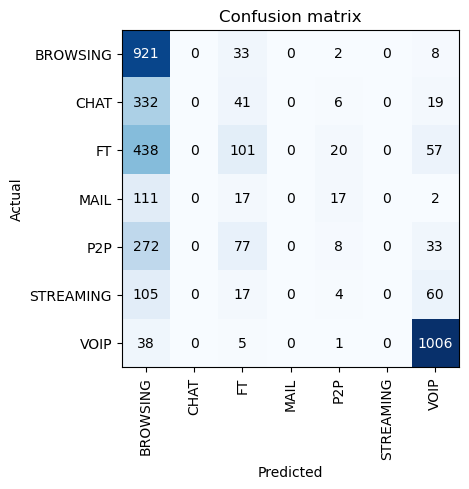

In [18]:

#adding dropout because it looks like the model began to only predict one class
results_flow_transformer_2 = run_torch_nn_experiment(
    df,
    dataset_1['File'],
    target_label='class1',
    model=FlowTransformer,
    # categorical=None, #would be nice if I could put None here instead of s
    config={
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.5,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    },
)



model = results_flow_transformer_2.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (18758, 24)
input features: 23
output features: 7


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 7])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.560491,1.350598,0.514796,0.273754,0.736262,0.407160,0.197680,0.159829,0.273754,00:06
1,1.339699,1.386726,0.528126,0.283855,0.729644,0.415160,0.214861,0.197116,0.283855,00:06
2,1.238738,1.281272,0.570515,0.337777,0.777778,0.462977,0.296225,0.297344,0.337777,00:05
3,1.178087,1.278160,0.563583,0.321562,0.765290,0.455847,0.277005,0.333448,0.321562,00:05
4,1.135774,1.105756,0.609971,0.380702,0.827648,0.510154,0.356243,0.408723,0.380702,00:05
5,1.097371,1.266000,0.596374,0.384875,0.778413,0.492131,0.364214,0.404442,0.384875,00:05
6,1.086890,1.513358,0.394561,0.302719,0.751016,0.281864,0.270785,0.371480,0.302719,00:05
7,1.082702,1.319168,0.480139,0.363926,0.778725,0.359024,0.353460,0.359860,0.363926,00:05
8,1.054372,1.155460,0.622234,0.416972,0.819466,0.524068,0.408297,0.446139,0.416972,00:05
9,1.061036,2.224101,0.287657,0.214776,0.644034,0.131274,0.203049,0.309908,0.214776,00:05


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


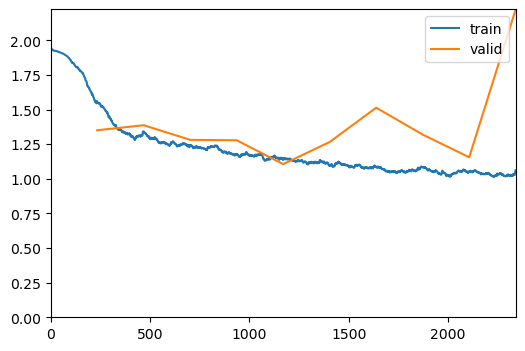

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\irworkstudy\AppData\Local\miniconda3\envs\ml-env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 2.2241010665893555, accuracy:  28.77%
Learnable Parameters: 			151733


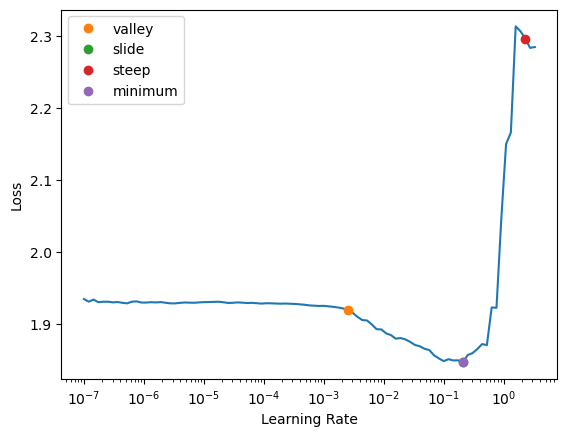

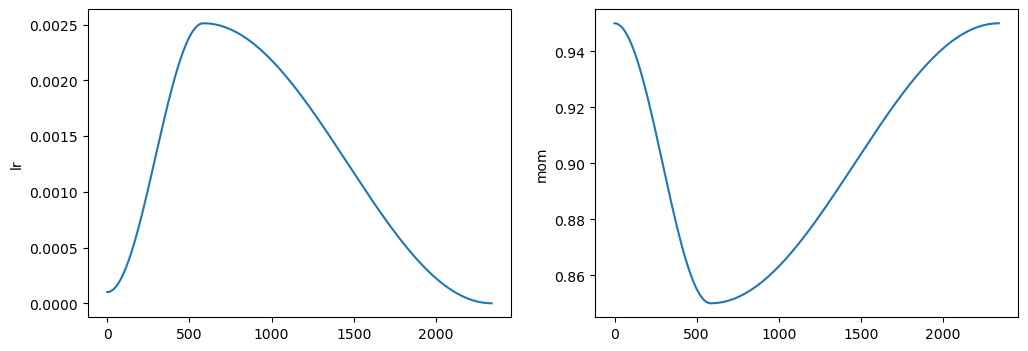

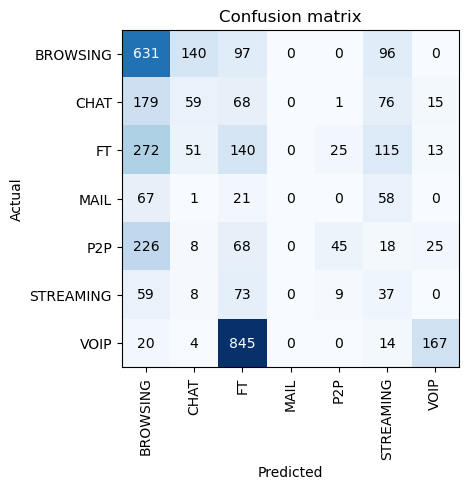

In [19]:

results_flow_transformer_3 = run_torch_nn_experiment(
    df,
    dataset_1['File'],
    target_label='class1',
    model=FlowTransformer,
    # categorical=None, #would be nice if I could put None here instead of using the wrong default
    config={
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': True,
            'dropout': 0.5,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    },
)


model = results_flow_transformer_3.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.546350,1.290986,0.605867,0.264801,0.730548,0.425944,0.239001,0.223113,0.264801,00:22
1,1.199873,1.053973,0.676020,0.295748,0.789888,0.534512,0.270706,0.252478,0.295748,00:22
2,1.123899,1.060971,0.661139,0.288614,0.812771,0.511940,0.264906,0.248329,0.288614,00:22
3,1.023647,0.953696,0.690051,0.315811,0.827845,0.557248,0.288123,0.277236,0.315811,00:21
4,0.965178,0.907201,0.687500,0.311143,0.861703,0.550315,0.283019,0.294572,0.311143,00:23
5,0.902139,0.847079,0.722789,0.400575,0.881568,0.605225,0.384581,0.389104,0.400575,00:22
6,0.856166,0.797366,0.736820,0.462478,0.889322,0.629803,0.480500,0.546442,0.462478,00:24
7,0.791374,0.755994,0.752551,0.478885,0.893549,0.651885,0.494125,0.547948,0.478885,00:20
8,0.770443,0.738370,0.754252,0.486773,0.898074,0.656363,0.497201,0.530161,0.486773,00:22
9,0.774774,0.789009,0.742347,0.470634,0.893479,0.634662,0.486554,0.544336,0.470634,00:24


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


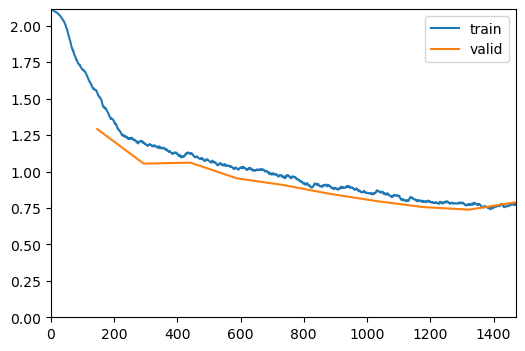

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.7890089154243469, accuracy:  74.23%
Learnable Parameters: 			212174


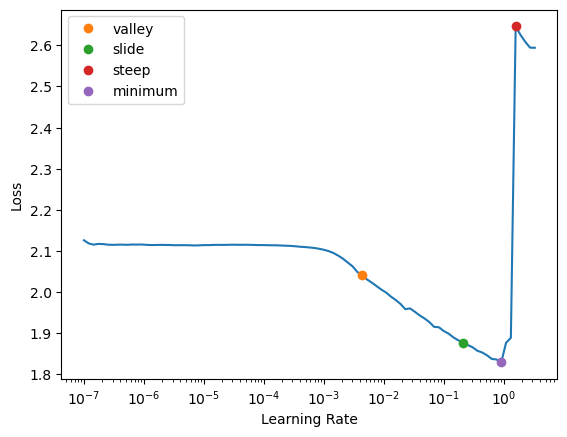

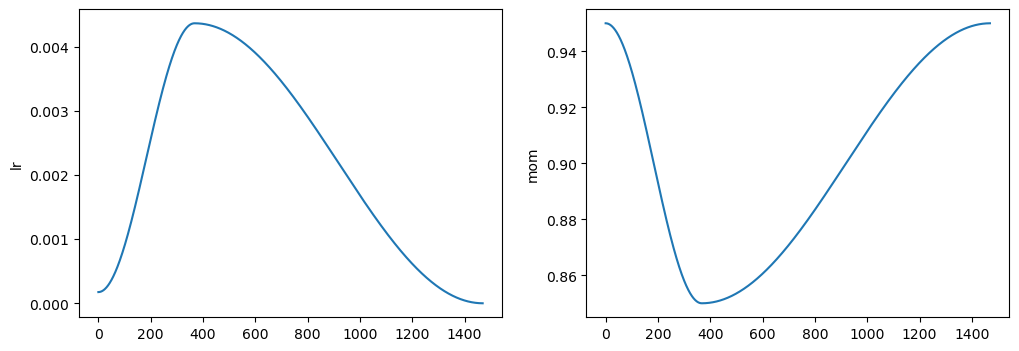

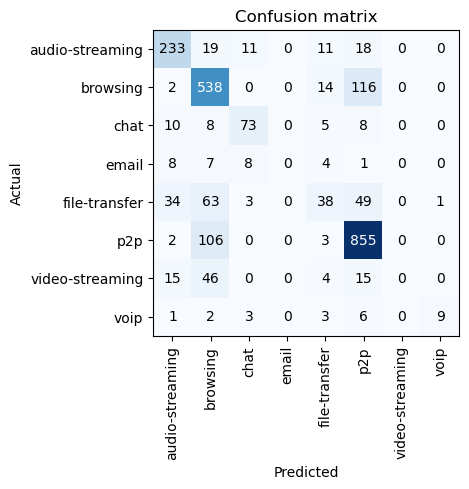

In [59]:

results_flow_transformer_4 = run_torch_nn_experiment(
    df,
    dataset_1['File'],
    target_label='class1',
    model=FlowTransformer,
    # categorical=None, #would be nice if I could put None here instead of s
    config={
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    },
)


model = results_flow_transformer_4.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.353658,1.035036,0.681548,0.307521,0.783100,0.555496,0.272910,0.249815,0.307521,00:17
1,0.927256,0.816455,0.747024,0.397890,0.879913,0.648532,0.383356,0.435301,0.397890,00:17
2,0.788994,0.790967,0.757653,0.440592,0.882549,0.657116,0.444949,0.475391,0.440592,00:16
3,0.714932,0.713551,0.782313,0.516300,0.906456,0.696834,0.512695,0.513507,0.516300,00:17
4,0.683190,0.655775,0.791241,0.528185,0.912732,0.708623,0.534907,0.614581,0.528185,00:18
5,0.621704,0.612029,0.804422,0.591033,0.923064,0.729124,0.607875,0.719449,0.591033,00:17
6,0.591015,0.617967,0.806548,0.571026,0.930528,0.734257,0.604393,0.779509,0.571026,00:17
7,0.556291,0.560240,0.816752,0.583860,0.934073,0.748013,0.595564,0.669503,0.583860,00:17
8,0.519827,0.542838,0.818878,0.594024,0.938050,0.750282,0.621753,0.716280,0.594024,00:17
9,0.498912,0.542677,0.820153,0.595301,0.938305,0.752312,0.619425,0.697603,0.595301,00:17


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


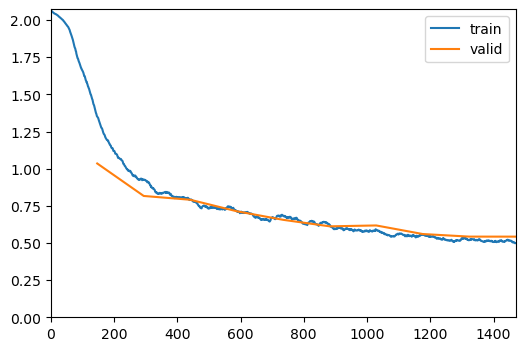

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.5426772236824036, accuracy:  82.02%
Learnable Parameters: 			105678


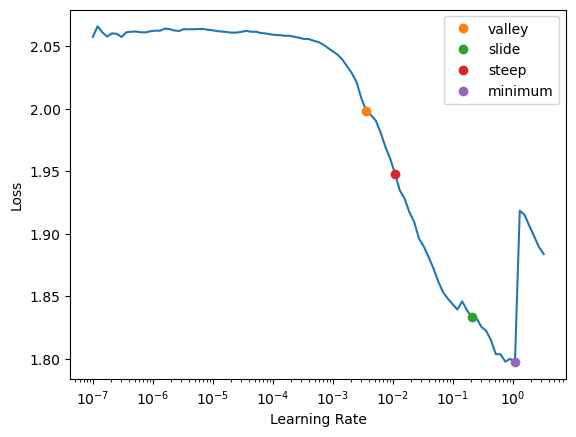

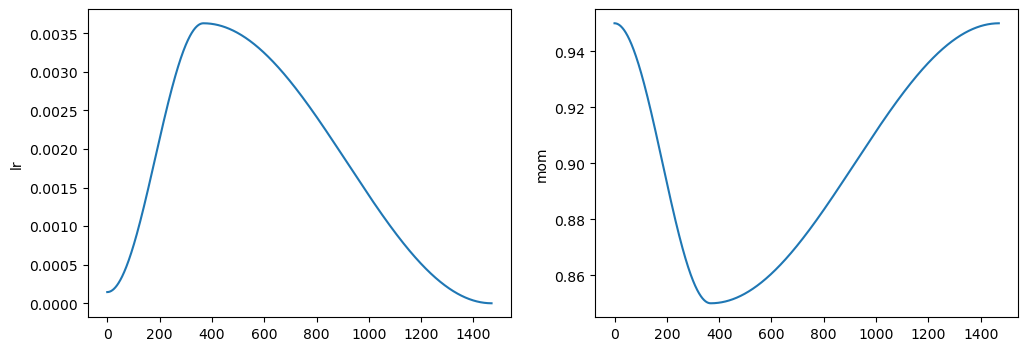

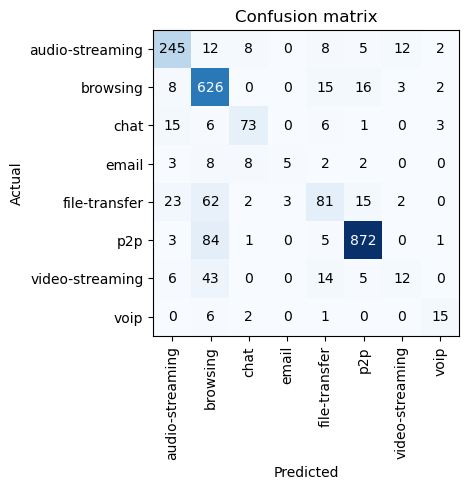

In [60]:

results_flow_transformer_5 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': False,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_5.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.308378,0.991713,0.692602,0.302472,0.836238,0.558158,0.275034,0.253344,0.302472,00:22
1,0.961495,0.855555,0.707483,0.322888,0.884673,0.589837,0.290986,0.321884,0.322888,00:22
2,0.931458,0.853908,0.710459,0.328272,0.859875,0.600970,0.286801,0.309925,0.328272,00:22
3,0.900764,0.817899,0.741497,0.414209,0.869519,0.638709,0.391896,0.398610,0.414209,00:22
4,0.811710,0.802472,0.735544,0.453914,0.887736,0.626270,0.465343,0.519229,0.453914,00:21
5,0.825498,0.795547,0.728741,0.445704,0.893272,0.632113,0.447633,0.507248,0.445704,00:21
6,0.758905,0.713080,0.756803,0.474533,0.898952,0.661407,0.488416,0.531023,0.474533,00:22
7,0.734682,0.702912,0.776361,0.486124,0.908245,0.688849,0.497840,0.535602,0.486124,00:22
8,0.687091,0.672802,0.767857,0.477048,0.916000,0.678068,0.488636,0.533366,0.477048,00:22
9,0.677794,0.666001,0.778486,0.489690,0.911870,0.691381,0.507413,0.569072,0.489690,00:22


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


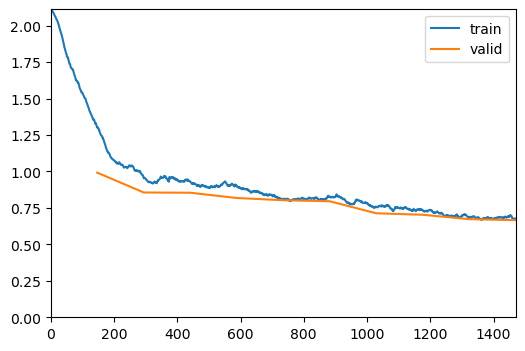

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.6660005450248718, accuracy:  77.85%
Learnable Parameters: 			212174


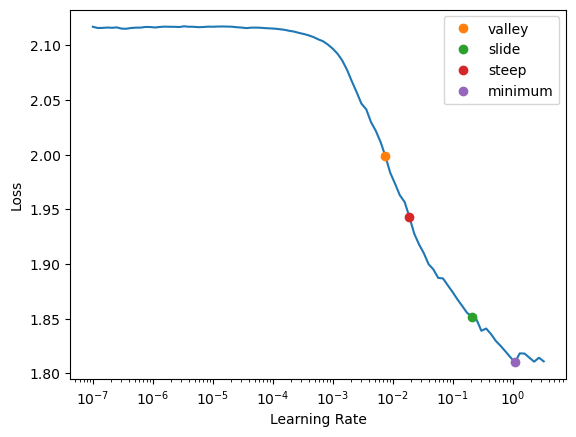

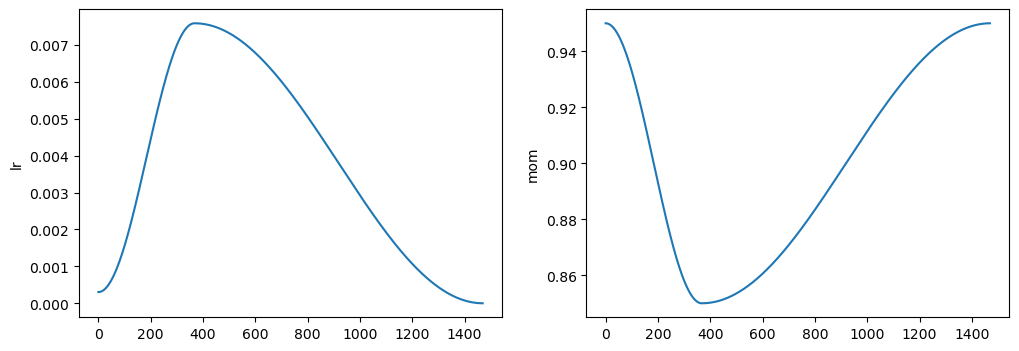

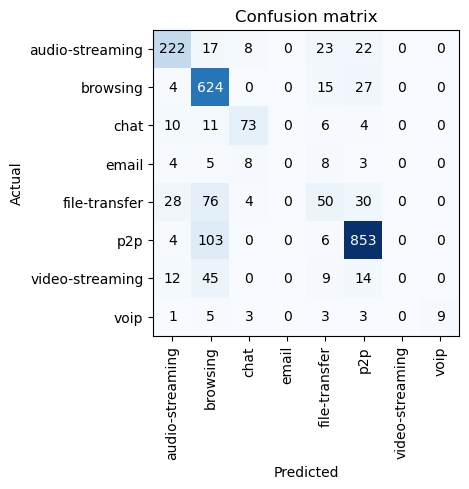

In [62]:

results_flow_transformer_6 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': .5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_6.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.521301,1.171282,0.633078,0.275011,0.725516,0.461413,0.257760,0.247223,0.275011,00:22
1,1.094621,0.992177,0.671769,0.293378,0.824009,0.524318,0.272158,0.268182,0.293378,00:22
2,0.972846,0.901969,0.693452,0.381588,0.872326,0.570647,0.377453,0.396458,0.381588,00:22
3,0.878878,0.813876,0.731293,0.418749,0.887820,0.617624,0.417607,0.422488,0.418749,00:22
4,0.812043,0.765515,0.755102,0.431293,0.900517,0.660321,0.428537,0.443325,0.431293,00:23
5,0.771751,0.726394,0.764881,0.491711,0.918112,0.676134,0.509007,0.569946,0.491711,00:22
6,0.723171,0.726226,0.754677,0.481904,0.909750,0.652647,0.496464,0.549167,0.481904,00:22
7,0.674461,0.668668,0.787840,0.525470,0.916816,0.703873,0.559177,0.739704,0.525470,00:22
8,0.661609,0.647359,0.781037,0.501147,0.923771,0.697428,0.520728,0.618860,0.501147,00:22
9,0.660963,0.631202,0.790816,0.533190,0.924855,0.709944,0.565052,0.732000,0.533190,00:22


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


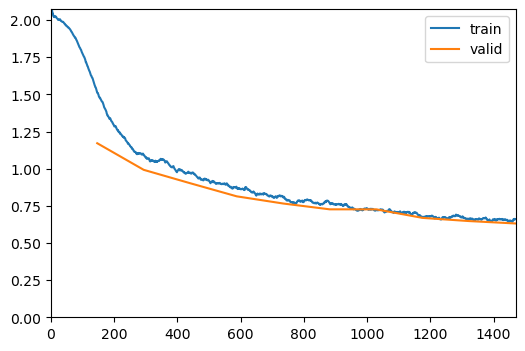

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

loss: 0.6312023997306824, accuracy:  79.08%
Learnable Parameters: 			212430


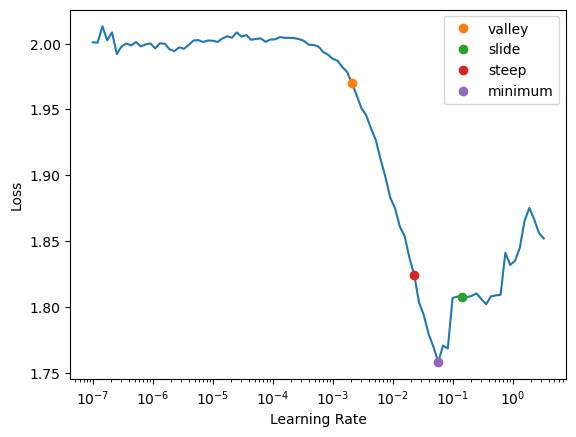

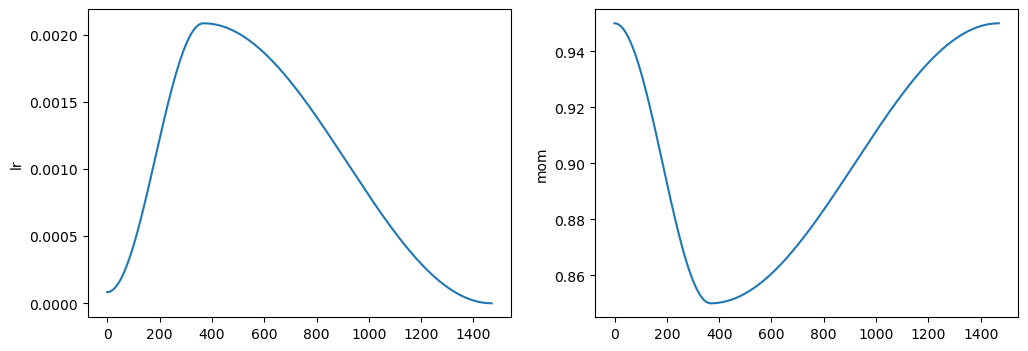

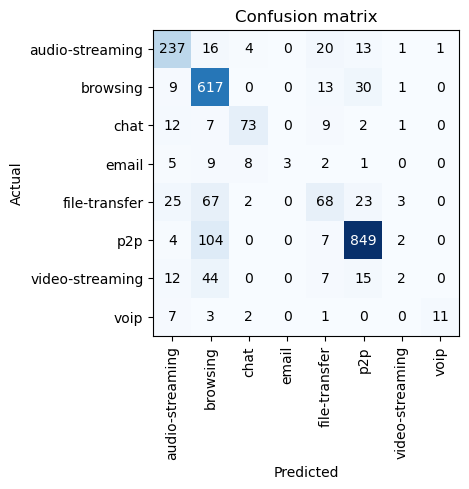

In [63]:

results_flow_transformer_6 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': True,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_6.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.561112,1.398246,0.418793,0.129459,0.717492,0.065650,0.089753,0.071814,0.129459,00:23
1,1.354267,1.269315,0.522959,0.245550,0.723201,0.330474,0.223073,0.215206,0.245550,00:23
2,1.345023,1.336738,0.519983,0.231883,0.667461,0.284926,0.215211,0.203532,0.231883,00:24
3,1.532351,1.550080,0.410714,0.125000,0.408665,0.000000,0.072785,0.051339,0.125000,00:23
4,1.544124,1.538725,0.410714,0.125000,0.547721,0.000000,0.072785,0.051339,0.125000,00:23
5,1.549489,1.539551,0.410714,0.125000,0.616430,0.000000,0.072785,0.051339,0.125000,00:23
6,1.545805,1.540397,0.410714,0.125000,0.661893,0.000000,0.072785,0.051339,0.125000,00:24
7,1.548160,1.537924,0.410714,0.125000,0.646431,0.000000,0.072785,0.051339,0.125000,00:23
8,1.537949,1.537814,0.410714,0.125000,0.635882,0.000000,0.072785,0.051339,0.125000,00:23
9,1.531895,1.537841,0.410714,0.125000,0.623919,0.000000,0.072785,0.051339,0.125000,00:23


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


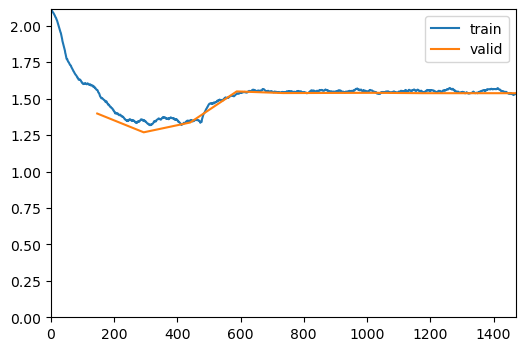

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.5378412008285522, accuracy:  41.07%
Learnable Parameters: 			212174


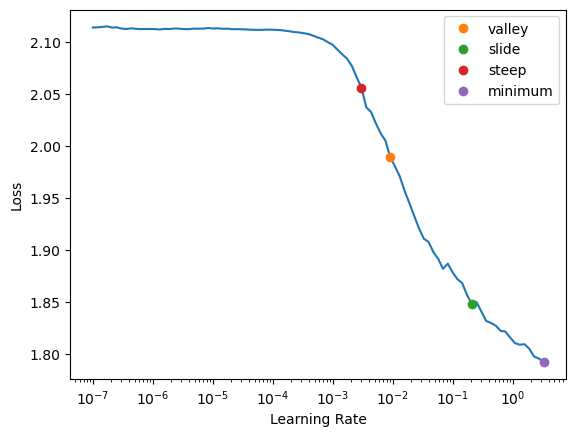

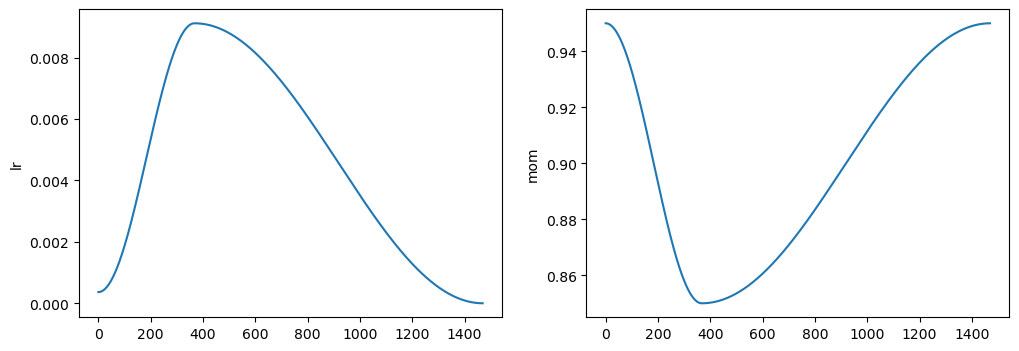

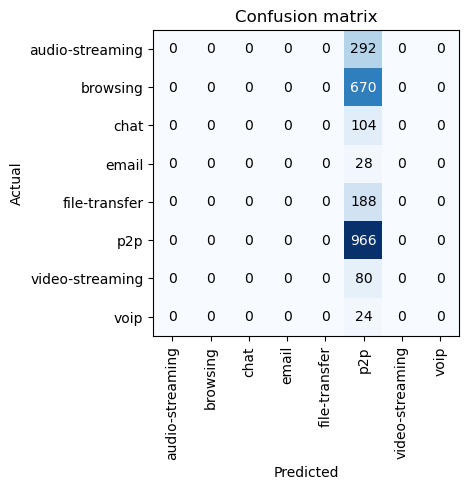

In [64]:

results_flow_transformer_6 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 8,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_6.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.623714,1.411425,0.520833,0.177494,0.678463,0.269388,0.145085,0.123039,0.177494,00:21
1,1.224535,1.043150,0.661565,0.293332,0.798256,0.511050,0.267284,0.246708,0.293332,00:21
2,1.104374,1.096353,0.625425,0.286462,0.797739,0.485510,0.256369,0.242519,0.286462,00:24
3,0.998557,0.919031,0.698980,0.366472,0.848410,0.575081,0.354368,0.356277,0.366472,00:22
4,0.945772,0.864835,0.705782,0.435026,0.877664,0.589725,0.417531,0.417290,0.435026,00:22
5,0.863139,0.804759,0.729167,0.449238,0.883010,0.616183,0.462723,0.535553,0.449238,00:21
6,0.809139,0.827186,0.726190,0.472779,0.888908,0.611271,0.489138,0.549042,0.472779,00:21
7,0.801681,0.799171,0.709609,0.464129,0.889748,0.605395,0.477763,0.539914,0.464129,00:22
8,0.761541,0.702848,0.772109,0.485878,0.905765,0.684460,0.500111,0.554166,0.485878,00:21
9,0.750364,0.788290,0.703231,0.474590,0.899285,0.604273,0.488960,0.551395,0.474590,00:22


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


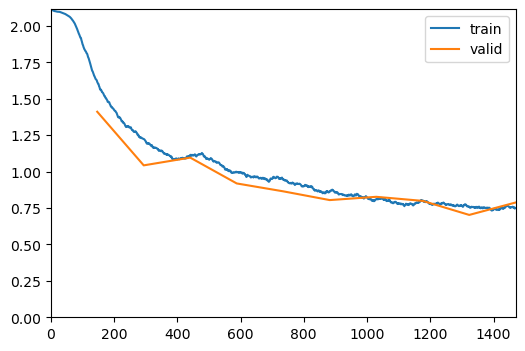

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 0.7882898449897766, accuracy:  70.32%
Learnable Parameters: 			212174


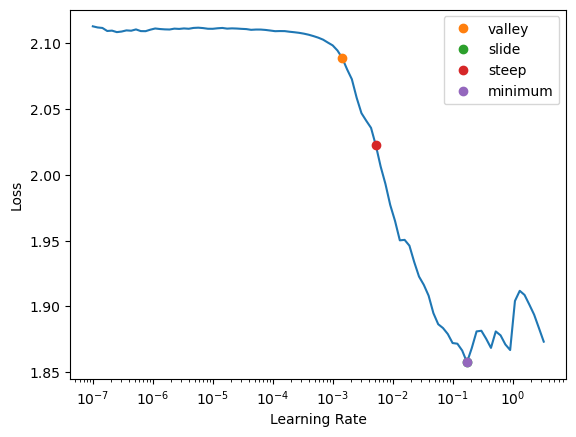

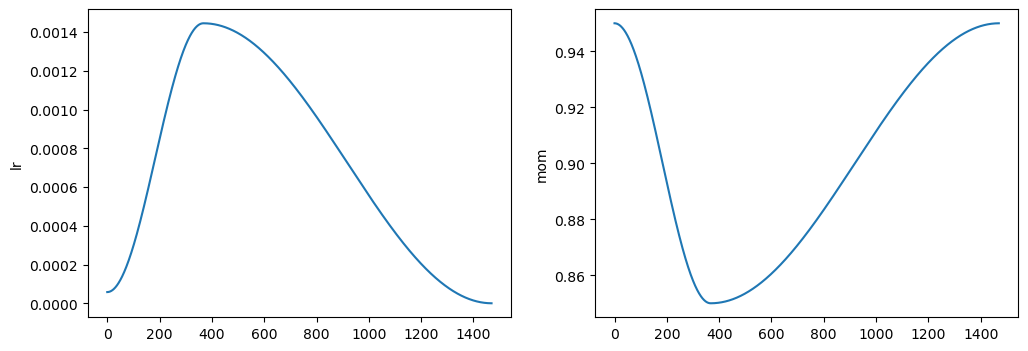

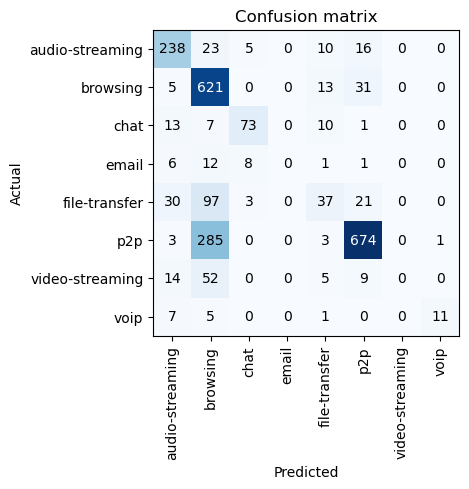

In [67]:

results_flow_transformer_7 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': True,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 1,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_7.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Shape of Input Data: (11762, 63)
input features: 64
output features: 8


Classification Head Layer 0: torch.Size([64, 64])
Classification Head Layer 1: torch.Size([64, 64])
embeddings shape: torch.Size([64, 64])
aggregated embeddings shape: torch.Size([64, 64])
output shape: torch.Size([64, 8])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,1.630907,1.544834,0.410714,0.125000,0.643743,0.000000,0.072785,0.051339,0.125000,00:28
1,1.530521,1.397807,0.489371,0.208377,0.675929,0.282293,0.156057,0.127575,0.208377,00:28
2,1.363757,1.318924,0.490646,0.206077,0.625136,0.291267,0.161320,0.140590,0.206077,00:28
3,1.346167,1.310620,0.491497,0.207530,0.692256,0.291551,0.161060,0.138253,0.207530,00:29
4,1.378984,1.343912,0.492347,0.208088,0.662117,0.293873,0.161784,0.139194,0.208088,00:28
5,1.334994,1.298482,0.517007,0.222715,0.720461,0.303990,0.185143,0.188023,0.222715,00:27
6,1.302035,1.252945,0.582058,0.252198,0.728895,0.386237,0.232961,0.224539,0.252198,00:28
7,1.272483,1.200450,0.598214,0.257529,0.724435,0.415081,0.237800,0.231362,0.257529,00:27
8,1.245972,1.190545,0.601190,0.261318,0.710273,0.414173,0.241302,0.228835,0.261318,00:28
9,1.230991,1.221893,0.584609,0.263221,0.692074,0.393918,0.242617,0.227299,0.263221,00:26


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


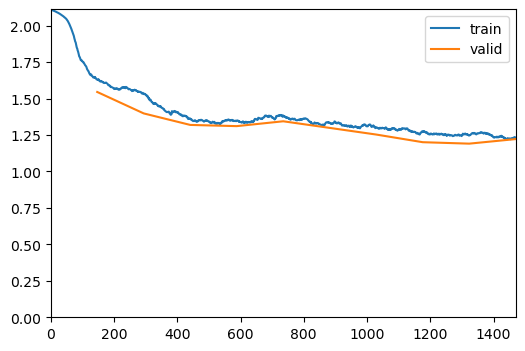

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/jameshalladay/opt/anaconda3/envs/fast/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss: 1.221893072128296, accuracy:  58.46%
Learnable Parameters: 			245454


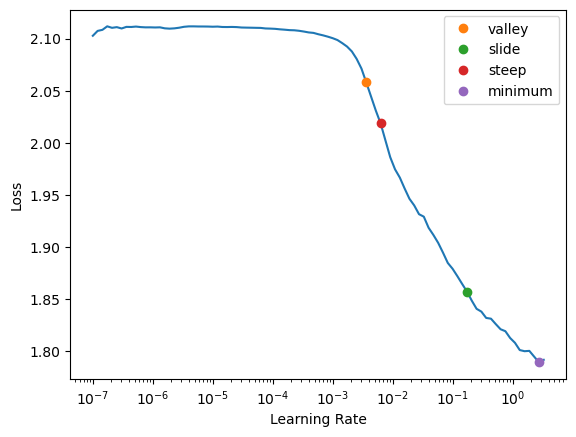

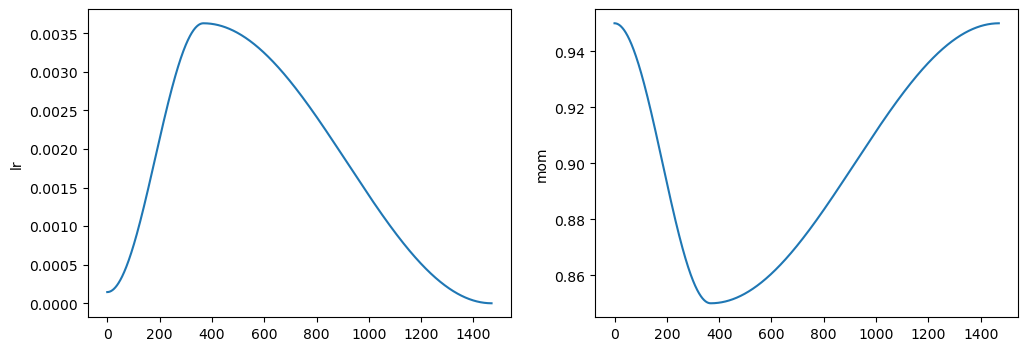

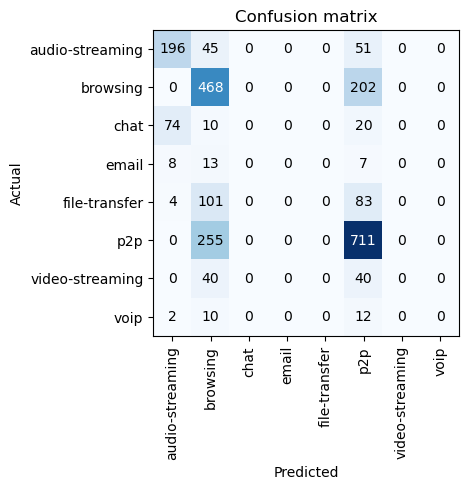

In [69]:

results_flow_transformer_8 = run_torch_nn_experiment(
    df.drop(['Traffic Type'], axis=1), 
    dataset_1['File'], 
    'Application Type', 
    FlowTransformer, 
    config = {
        'feature_groups': feature_groups,
        'activation': nn.ReLU(),
        'verbose': True,
        'embeddings': {
            'embedding_size': 64,
            'use_rff': True,
            'rff_dim': 64,
            'rff_std': 2.5,
            'learnable_rff_std': False,
        },
        'encoder':{
            'layers': 2,
            'heads': 4,
            'forward_expansion': 2,
            'pre_norm': False,
            'dropout': 0.0,
        },
        'aggregation': {
            'type': 'LSTM',
            'layers': 2,
        },
        'classification_head': {
            'layers': 2,
            'hidden_size': 64,
            'batch_norm': False,
            'activation': nn.ReLU(),
        }
    }
)


model = results_flow_transformer_8.model.model.model

print(f"Learnable Parameters: \t\t\t{sum(p.numel() for p in model.parameters() if p.requires_grad)}")